In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

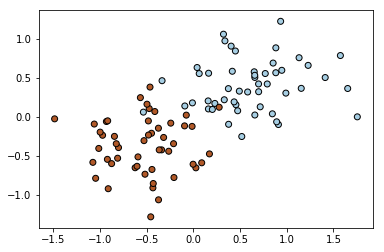

In [14]:
def generate_dual_gaussian_dataset(num_points = 50):
    X = np.zeros((2, num_points * 2))
    Y = np.zeros((2, num_points * 2))
    for i in range(0, num_points):
        X[0, i*2] = np.random.normal(0.5, 0.4)
        X[1, i*2] = np.random.normal(0.5, 0.4)
        X[0, i*2 + 1] = np.random.normal(-0.5, 0.4)
        X[1, i*2 + 1] = np.random.normal(-0.5, 0.4)
        Y[0, i*2] = 1
        Y[1, i*2 + 1] = 1
    return X, Y

X, Y = generate_dual_gaussian_dataset()

plt.scatter(X[0, :], X[1, :], edgecolor = '0', c = np.argmax(Y, axis = 0), cmap = plt.cm.Paired)
plt.show()

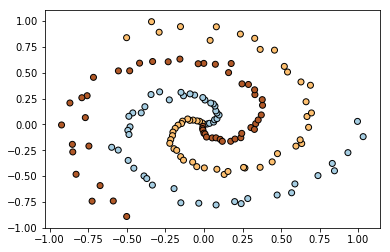

In [21]:
def generate_spiral_dataset(num_points = 50):
    X = np.zeros((2, num_points * 3))
    Y = np.zeros((3, num_points * 3))
    for i in range(0, num_points):
        d = (i+1) / num_points
        for j in range(3):
            X[0, i*3 + j] = d * math.cos(2 * d * math.pi + 2 * math.pi * j / 3) + np.random.normal(0, d * 0.05)
            X[1, i*3 + j] = d * math.sin(2 * d * math.pi + 2 * math.pi * j / 3) + np.random.normal(0, d * 0.05)
            Y[j, i*3 + j] = 1
    return X, Y

X, Y = generate_spiral_dataset()

plt.scatter(X[0, :], X[1, :], edgecolor = '0', c = np.argmax(Y, axis = 0), cmap = plt.cm.Paired)
plt.show()

In [4]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [5]:
def softmax(Z):
    Z = Z - np.max(Z, axis = 0, keepdims = True)
    e = np.exp(Z)
    d = np.sum(e, axis = 0, keepdims = True)
    return e / d

In [6]:
def cross_entropy_loss(A, Y):
    m = Y.shape[1]
    J = -np.sum(Y * np.log(np.maximum(A, 1e-10)), axis = 0, keepdims = True)
    return np.sum(J) / m

In [7]:
class Layer:
    def __init__(self, n_inputs, n_outputs, activation, learning_rate, lambd, beta):
        if activation == 'relu':
            initialization = np.sqrt(2.0 / n_inputs)
        else:
            # N.B., Xavier init --- technically only for tanh, but we use it for anything else?
            initialization = np.sqrt(1.0 / n_inputs)
        self.W = np.random.randn(n_outputs, n_inputs) * initialization
        self.b = np.zeros((n_outputs, 1))
        self.momentum_dW = np.zeros((n_outputs, n_inputs))
        self.momentum_db = np.zeros((n_outputs, 1))
        self.activation = activation
        self.learning_rate = learning_rate
        self.lambd = lambd
        self.beta = beta
        
    @property
    def n_inputs(self):
        return self.W.shape[1]
    
    @property
    def n_outputs(self):
        return self.W.shape[0]
    
    def regularization_loss(self, m):
        return self.lambd * np.linalg.norm(self.W, 'fro') / (2 * m)
    
    def forward_propagate(self, X):
        Z = np.matmul(self.W, X) + self.b
        A = self.activate(Z)
        return A
    
    def backward_propagate_output(self, X, A, Y):
        if self.activation == 'sigmoid' or self.activation == 'softmax':
            dZ = A - Y
        else:
            raise Exception('unsupported activation function')
        return self._backward_propagate_dZ(X, A, dZ)
    
    def backward_propagate(self, X, A, dA):
        if self.activation == 'tanh':
            dZ = dA * (1 - np.square(A))
        elif self.activation == 'sigmoid':
            dZ = dA * A * (1 - A)
        elif self.activation == 'relu':
            dZ = dA * np.ceil(np.clip(A, 0, 1))
        else:
            raise Exception('unsupported activation function')
        return self._backward_propagate_dZ(X, A, dZ)
    
    def _backward_propagate_dZ(self, X, A, dZ):
        m = Y.shape[1]
        dW = (np.matmul(dZ, X.T) + self.lambd * self.W) / m
        db = np.sum(dZ, axis = 1, keepdims = True) / m
        dA_prev = np.matmul(self.W.T, dZ)
        self.momentum_dW = self.beta * self.momentum_dW + (1 - self.beta) * dW
        self.momentum_db = self.beta * self.momentum_db + (1 - self.beta) * db
        self.W = self.W - self.learning_rate * self.momentum_dW
        self.b = self.b - self.learning_rate * self.momentum_db
        return dA_prev
    
    def activate(self, Z):
        if self.activation == 'tanh':
            return np.tanh(Z)
        elif self.activation == 'sigmoid':
            return sigmoid(Z)
        elif self.activation == 'softmax':
            return softmax(Z)
        elif self.activation == 'relu':
            return np.maximum(Z, 0)
        else:
            raise Exception('unsupported activation function')

In [8]:
class Network:
    def __init__(self, layers):
        self.layers = layers
    
    def train(self, X, Y, iterations, loss_freq = 1000):
        m = Y.shape[1]
        
        for i in range(iterations):
            As = [X]
            for layer in self.layers:
                As.append(layer.forward_propagate(As[-1]))
                
            if i % loss_freq == 0:
                self.print_loss(As[-1], Y)

            dA = self.layers[-1].backward_propagate_output(As[-2], As[-1], Y)
            for i in range(len(self.layers) - 2, -1, -1):
                layer = self.layers[i]
                A_input = As[i]
                A_output = As[i+1]
                dA = layer.backward_propagate(A_input, A_output, dA)
        
        self.print_loss(self.predict(X), Y)
    
    def print_loss(self, A, Y):
        m = Y.shape[1]
        ce_loss = cross_entropy_loss(A, Y)
        reg_loss = 0
        for layer in self.layers:
            reg_loss += layer.regularization_loss(m)
        print('loss: %f, ce_loss: %f, reg_loss: %f' % \
              (ce_loss + reg_loss, ce_loss, reg_loss))
    
    def predict(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward_propagate(A)
        return A

In [31]:
layer_sizes = [X.shape[0], 20, 10, Y.shape[0]]
layer_activations = ['relu', 'relu', 'softmax']
layers = []
for i in range(len(layer_sizes) - 1):
    layers.append(Layer(
        n_inputs = layer_sizes[i], 
        n_outputs = layer_sizes[i+1], 
        activation = layer_activations[i],
        learning_rate = 0.3,
        lambd = 0.2,
        beta = 0.9))
network = Network(layers)

network.train(X, Y, 20000, loss_freq = 2000)

loss: 1.118016, ce_loss: 1.110072, reg_loss: 0.007944
loss: 0.071495, ce_loss: 0.054224, reg_loss: 0.017271
loss: 0.065292, ce_loss: 0.048275, reg_loss: 0.017018
loss: 0.062866, ce_loss: 0.046039, reg_loss: 0.016828
loss: 0.061682, ce_loss: 0.044971, reg_loss: 0.016711
loss: 0.061212, ce_loss: 0.044551, reg_loss: 0.016661
loss: 0.060818, ce_loss: 0.044180, reg_loss: 0.016638
loss: 0.060520, ce_loss: 0.043896, reg_loss: 0.016624
loss: 0.060279, ce_loss: 0.043663, reg_loss: 0.016617
loss: 0.059188, ce_loss: 0.042635, reg_loss: 0.016553
loss: 0.058967, ce_loss: 0.042489, reg_loss: 0.016478


In [10]:
# reference: https://stackoverflow.com/questions/19054923/plot-decision-boundary-matplotlib?answertab=oldest#tab-top

def plot_decision_boundary(X, Y, model):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_mesh = np.c_[xx.ravel(), yy.ravel()].T
    A_mesh = model(X_mesh)
    Y_mesh = np.argmax(A_mesh, axis=0)
    Y_mesh = Y_mesh.reshape(xx.shape)
    plt.contourf(xx, yy, Y_mesh, cmap=plt.cm.Paired)
    plt.scatter(X[0, :], X[1, :], edgecolor = '0', c = np.argmax(Y, axis = 0), cmap = plt.cm.Paired)
    plt.show()

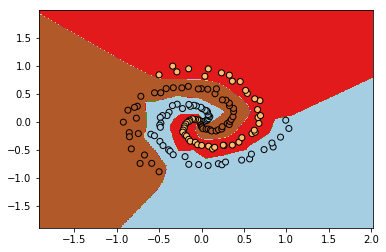

In [32]:
plot_decision_boundary(X, Y, lambda X: network.predict(X))